# Lecture 07 - Fitting Over & Under

In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))  # make src importable

# Project modules
import init_notebook
import utils

# Third-party libs – explicit per notebook
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr
import graphviz as gr
import statsmodels.formula.api as smf

# Run the setup
init_notebook.setup()

Using style file: /Users/gharda/Documents/Code/statistical-rethinking-pymc/statistical-rethinking-pymc.mplstyle
Module aliases imported by init_notebook.py:
--------------------------------------------
import np
import pd
import smf
import pm
import xr
import az
import stats
import plt
import utils
Watermark:
----------
Last updated: 2025-12-27T15:41:36.353581+07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.7.0

Compiler    : Clang 17.0.0 (clang-1700.3.19.1)
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pymc       : 5.26.1
pandas     : 2.3.3
numpy      : 2.3.5
watermark  : 2.5.0
xarray     : 2025.11.0
pytensor   : 2.35.1
statsmodels: 0.14.5
matplotlib : 3.10.7
arviz      : 0.22.0
pathlib    : 1.0.1
scipy      : 1.16.3



# Infinite causes, finite data
- There are an infinite number of estimators that could explain a given sample
- Often there is a tradeoff between simplicity (parsimony) and accuracy

## Two simultaneous struggles
1. Causation: using logic and causal assumptions to design estimators; comparing and contrast alternative models
2. Finite Data: how to make estimators work
    - the existence of an estimator is not enough, and having estimator doesn't mean that it's practical or possible to estimate
    - we need to think about the engineering considerations around estimations

## Problems of prediction

#### Create Toy Brain Volumes Dataset

In [2]:
species = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brain_volume_cc = [438 , 452 , 612, 521, 752, 871, 1350]
mass_kg = [37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5]

BRAIN_MASS_TOY = pd.DataFrame(
    {
        'species': species,
        'brain': brain_volume_cc,
        'mass': mass_kg
    }
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


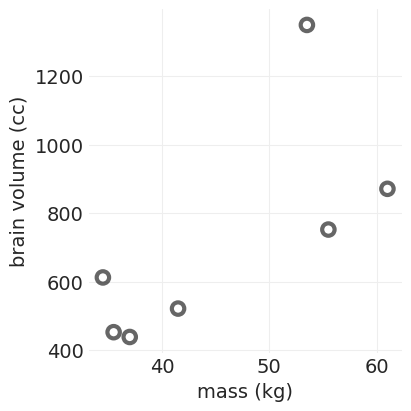

In [3]:
def plot_brain_mass_data(ax=None, data=BRAIN_MASS_TOY):
    if ax is not None:
        plt.sca(ax)
    utils.plot_scatter(data.mass, data.brain, color='k')
    plt.xlabel('mass (kg)')
    plt.ylabel('brain volume (cc)')
    
_, ax = plt.subplots(figsize=(4, 4))
plot_brain_mass_data(ax)

### Considerations
- what possible functions **describe** these points
    - **curve fitting & compression**
- what possible functions **explain** these points
    - this is the goal of **causal inference**
- what would happen if we changed one of the points mass?
    - **intervention**
- given a new mass, what's the **expected value** of corresponding volume
    - **prediction**

## Leave-one-out Cross Validation (LOCVV)
Process for determining the ability for a model function to generalize -- i.e. accurately predicting **out-of-sample** data points.
1. Drop one data point
2. Fit the model function's parameters with the data point missing
3. Predict the value of the dropped point, record the error
4. Repeat 1-3 for all data points
5. The LOCVV score is the sum of errors on all the dropped points

In [4]:
def fit_polynomial_cross_validated(order, data):
    n_data_points = len(data)
    data_idx = np.arange(n_data_points)
    params = []
    for ii in range(n_data_points):
        shift = n_data_points - 1 - ii
        cross_val_idx = sorted(np.roll(data_idx, shift)[:n_data_points-1])
        
        cross_val_x = data.mass[cross_val_idx]
        cross_val_y = data.brain[cross_val_idx]
        cross_val_params = np.polyfit(cross_val_x, cross_val_y, order)
        params.append(cross_val_params)
    return np.array(params)

def estimate_n_degree_model_crossvalidated(order, data, ylims=(300, 1400)):
    cross_val_params = fit_polynomial_cross_validated(order, data)
    insample_model = np.poly1d(np.polyfit(data.mass, data.brain, order))
    
    ca = plt.gca()
    plot_brain_mass_data(ax=ca, data=data)
    
    out_of_sample_error = 0
    insample_error = 0
    
    xs = np.linspace(data.mass.min(), data.mass.max(), 100)
    for holdout_idx, params in enumerate(cross_val_params):
        model = np.poly1d(params)
        ys = model(xs)
        utils.plot_line(xs, ys, color='gray', label=None, alpha=.25)
        
        holdout_x = data.loc[holdout_idx, 'mass']
        holdout_y = data.loc[holdout_idx, 'brain']
        
        holdout_prediction = model(holdout_x)
        insample_prediction = insample_model(holdout_x)
        
        # Here we use absolute error
        holdout_error = np.abs(holdout_prediction - holdout_y)
        insample_error_ = np.abs(insample_prediction - holdout_y)
        
        out_of_sample_error += holdout_error
        insample_error += insample_error_
    
    ys = insample_model(xs)
    utils.plot_line(xs, ys, color='C1', linewidth=6, label="Average Model")
    plt.ylim(ylims)
    plt.title(f"Polynomial Terms: {order}\nIn-sample: {insample_error:1.0f}\nOut-of-sample: {out_of_sample_error:1.0f}")
    
    return insample_error, out_of_sample_error

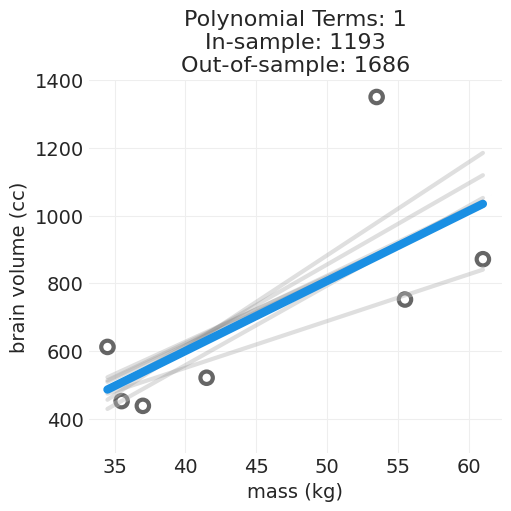

In [5]:
plt.subplots(figsize=(5, 5))
insample_error, outsample_error = estimate_n_degree_model_crossvalidated(1, data=BRAIN_MASS_TOY)

## Comparing Polynomial Models with LO0CV

In [29]:
def simulate_n_degree_polynomial_overfitting(data, ylims=(300, 1200)):
    fig, axs = plt.subplots(3, 2, figsize=(10, 12))
    insample_errors = []
    outsample_errors = []
    for ii in range(1, 6):
        row = (ii - 1) // 2
        col = (ii - 1) % 2
        plt.sca(axs[row, col])
        insample_error, outsample_error = estimate_n_degree_model_crossvalidated(ii, data=data, ylims=ylims)
        insample_errors.append(insample_error)
        outsample_errors.append(outsample_error)
    
    # rescale errors
    insample_errors = np.array(insample_errors)
    relative_insample_errors = insample_errors / insample_errors.sum()
    outsample_errors = np.array(outsample_errors)
    relative_outsample_errors = outsample_errors / outsample_errors.sum()
    
    plt.sca(axs[-1, 1])
    xs = np.arange(1, 6)
    
    utils.plot_line(xs, relative_insample_errors, color='C1', label='in-sample', alpha=1)
    utils.plot_scatter(xs, relative_insample_errors, color='C1', label=None, zorder=100, alpha=1, facecolors='w')
    
    utils.plot_line(xs, relative_outsample_errors, color='C0', label='out-of-sample', alpha=1)
    utils.plot_scatter(xs, relative_outsample_errors, color='C0', label=None, zorder=100, alpha=1, facecolors='w')
    plt.xlabel("polynomial terms")
    plt.ylabel("relative error")
    plt.legend();
    
    return outsample_errors, insample_errors

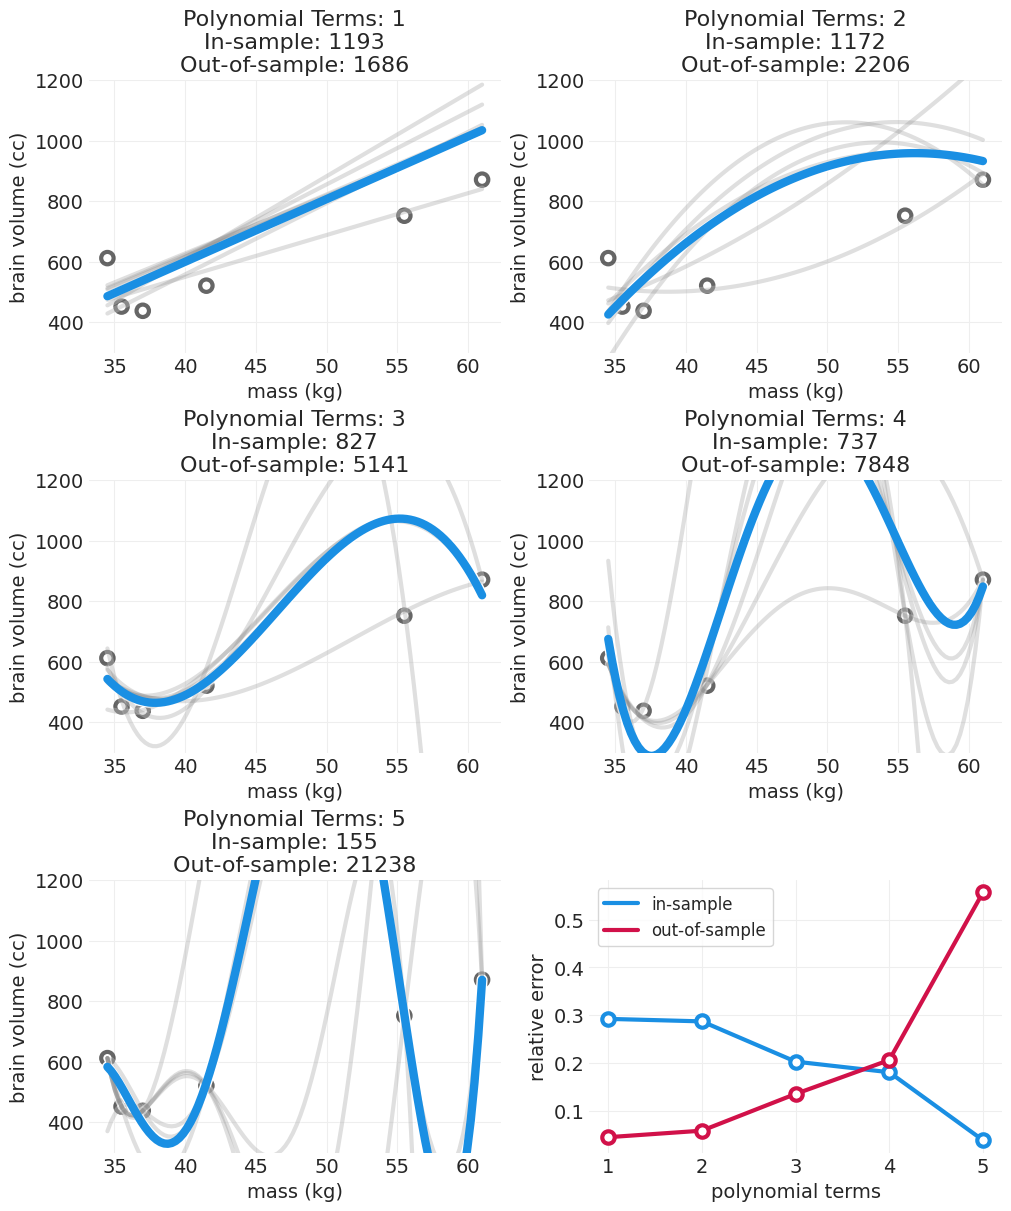

In [30]:
outsample_error, insample_error = simulate_n_degree_polynomial_overfitting(data=BRAIN_MASS_TOY)

As we increase the polynomial order
- The in-sample error reduces
- The out-of-sample error SKYROCKETS
- (at least for simple models) There's a tradeoff between model simplicity and complexity that is mirrored by the amount of in-sample and out-of-sample error
- There will be a "sweet spot" in model complexity that is just complex enough to fit the data, but not too complex to overfit the noise
- This is known as the bias-variance tradeoff

**NOTE** this is all applicable to the goal of **prediction**, not causal inference

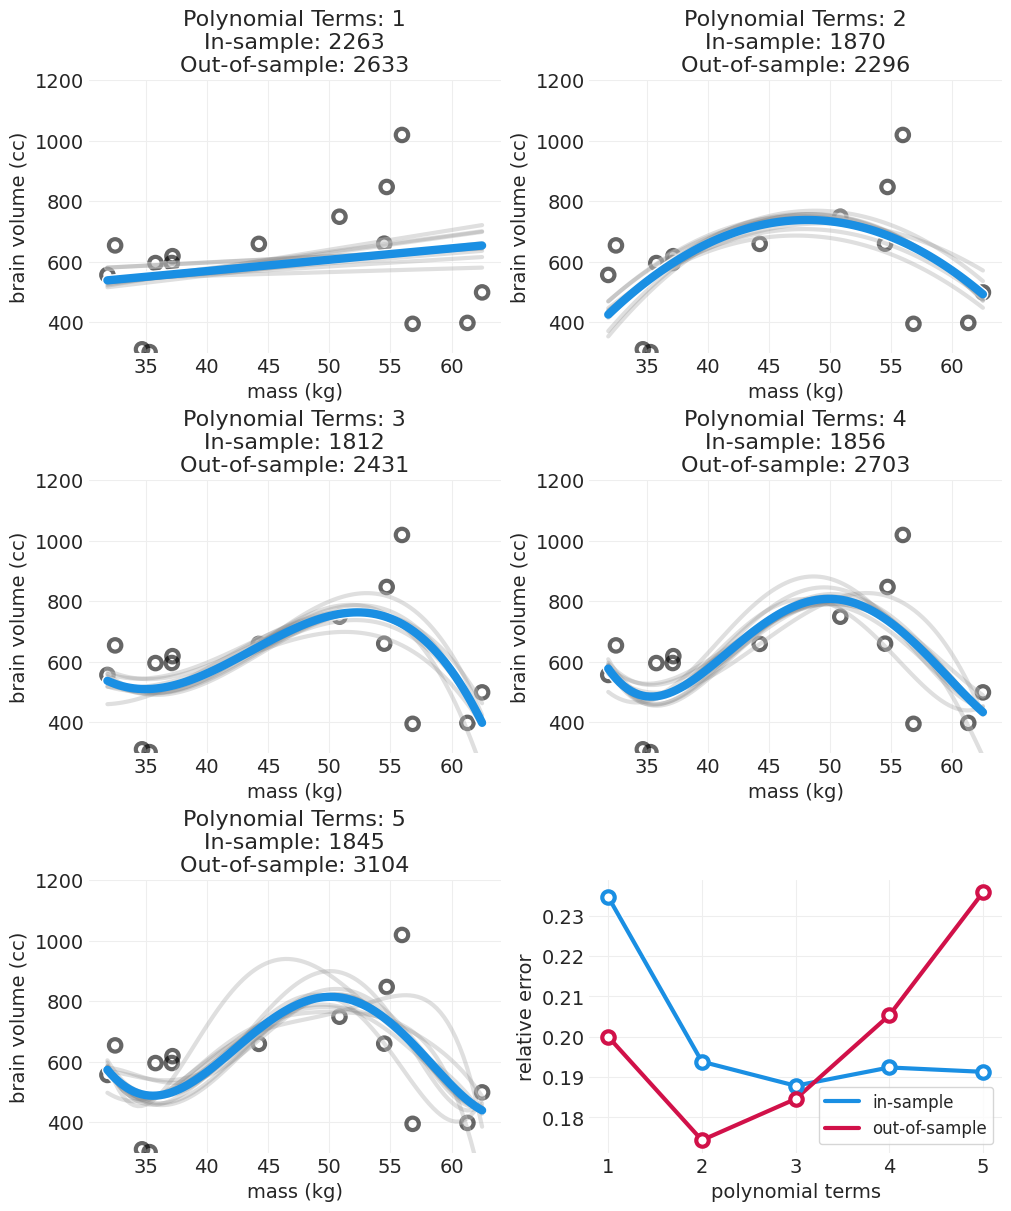

In [31]:
np.random.seed(1234)
n_samples = 15
# Run simulation with more data points
PRIMATE_DATA = utils.load_data('Primates301')[['brain', 'body']].dropna()

# preprocess the data a little
PRIMATE_DATA.loc[:, 'brain'] = PRIMATE_DATA.brain * 10
PRIMATE_DATA.loc[:, 'mass'] = PRIMATE_DATA.body / 100
PRIMATE_DATA = PRIMATE_DATA[PRIMATE_DATA.mass >= 30]
PRIMATE_DATA = PRIMATE_DATA[PRIMATE_DATA.mass <= 65]
PRIMATE_DATA = PRIMATE_DATA[PRIMATE_DATA.mass <= 900]

PRIMATE_DATA = PRIMATE_DATA.sample(n=n_samples).reset_index(drop=True)

np.random.seed(1234)
outsample_error, insample_error = simulate_n_degree_polynomial_overfitting(data=PRIMATE_DATA)

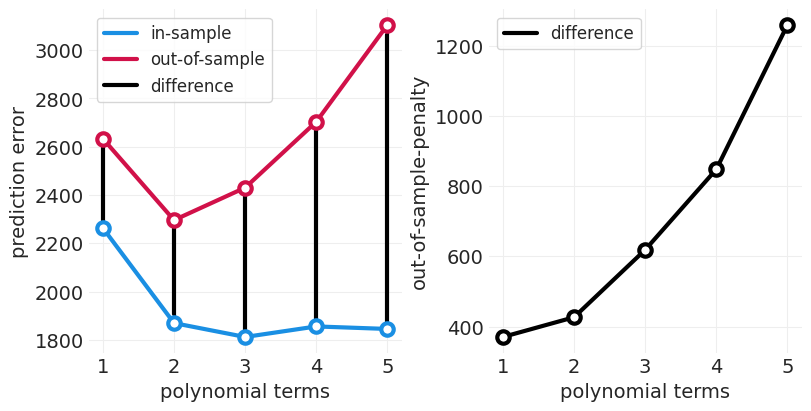

In [32]:
def plot_out_of_sample_penalty(outsample_error, insample_error):
    penalty = outsample_error - insample_error
    n_terms = len(penalty)
    xs = np.arange(1, n_terms + 1)
    
    _, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.sca(axs[0])
    utils.plot_scatter(xs, insample_error, color='C1', label=None, zorder=100, alpha=1, facecolors='w')
    utils.plot_line(xs, insample_error, color='C1', label='in-sample', alpha=1)
    
    utils.plot_scatter(xs, outsample_error, color='C0', label=None, zorder=100, alpha=1, facecolors='w')
    utils.plot_line(xs, outsample_error, color='C0', label='out-of-sample', alpha=1)
    
    for ii, (out, inn), in enumerate(zip(outsample_error, insample_error)):
        label = 'difference' if not ii else None
        plt.plot((ii + 1, ii + 1), (out, inn), color='k', lw=3, label=label)
        
    plt.ylabel('prediction error')
    plt.xlabel('polynomial terms')
    plt.legend()
    
    plt.sca(axs[1])
    utils.plot_scatter(xs, penalty, color='black', label=None, zorder=100, alpha=1, facecolors='w')
    utils.plot_line(xs, penalty, color='black', label='difference', alpha=1)
    plt.xlabel('polynomial terms')
    plt.xticks(xs)
    plt.ylabel('out-of-sample-penalty')
    plt.legend()
    
plot_out_of_sample_penalty(outsample_error, insample_error)

## Regularization
- There will be a tradeoff between model flexibility and accuracy. Having a model that's too flexible can lead to overeighting the contribution of noise
- Do not want your estimator to get too excited about rare outlier events. You want it to find **regular features.**
- Bayesian modeling uses tighter priors (in terms of variance) in order to be skeptical of unlikely events, tampering down the estimator's dendency to "get excited" about outlier events, thus reducing the model's flexibility to model those outliers.
    - Good priors are often tighter than one thinks
- The goal isn't signal compression (i.e. memorizing all features of the data), it is generalization in predictions.
> Cross validation is not regularization: CV can be used to compare models, but not to reduce flexibility (though we could average models)

### Regularizing Priors
- Use science: there's no replacement for domain knowledge
- Can tune priors with using CV
- Many tasks are a mix of inference and prediction, so weight the ability to predict and make actionable inferences

If we define the out-of-sample-penalty (OOSP) as the difference between the out-of-sample and in-sample error, we can see that as model complexity increases, so does the OOSP. We can use this metric for comparing models of different form and complexity by providing a signal for overfitting.

> McElreath goes on to show that Bayesian cross-validation metrics WAIC and PSIS closely track the OOSP returned by brute-force LOOCV (via the proxy lppd). It would be nice to replicate that chart in Python/PyMC, however, that's a lot of extra coding and model estimation for one plot, so I'm going to skip that one for now. That said, I'll show in the section on Robust Regression an example of using WAIC and PSIS returned from the PyMC.

## Penalty Prediction & Model (Mis-) Selection

For the simple example above, runing cross-validation to obtain in- and out-of-sample penality is no big deal. However, for more complex models that may take a long time to train, retraining multiple times can be prohibitive. Luckily there are some approximations to the CV procedure that allow us to obtain similar metrics directly from Bayesian models without having to explicitly run CV. These metrics include

- Pareto-smoothed Importance Sampling (PSIS)
- Waikake's Information Criterion (WAIC)

> When directly addressing causal inference problems, **do not use CV Penalties for selecting causal models**, this can result in selecting a confounded model. **Confounds often aid with prediction in the absence of intervention** by milking all association signals. However, there are many associations that we do not want to include when addressing causal problems.

### Example: Simulated Fungus Growth
The following is a translation of R code 6.13 from McElreath's v2 textbook that's used to simulate fungus growth on plants.

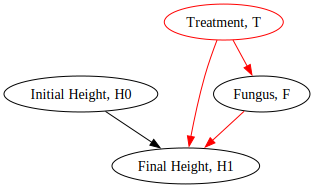

In [33]:
utils.draw_causal_graph(
    edge_list=[
        ("H0", "H1"),
        ("T", "H1"),
        ("T", "F"),
        ("F", "H1")
    ],
    node_props={
        "T": {"label": "Treatment, T", "color": "red"},
        "F": {"label": "Fungus, F"},
        "H0": {"label": "Initial Height, H0"},
        "H1": {"label": "Final Height, H1"},
    },
    edge_props={
        ("T", "F"): {"color": "red"},
        ("F", "H1"): {"color": "red"},
        ("T", "H1"): {"color": "red"}
    }
)

### Simulate the plant growth experiment